In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from json import loads, dumps
from ipywidgets import widgets
from IPython.display import display

In [ ]:
from glob import glob

def gather_runs(append=False):
    glob_path = "./implementation/test/history/**/*.json"

    runs = []
    for run_output_filepath in glob(glob_path, recursive=True):
        with open(run_output_filepath) as run_output:
            run_json = loads(run_output.read())
            runs.append(run_json)

    if append:
        with open("./data.json", "r") as data_file:
            print(data_file)
            data = loads(data_file.read())
            runs.extend(data)

    if not runs:
        raise Exception("No runs found. Keeping old data.")
    else:
        print(f"Found {len(runs)} runs")

    with open("./data.json", "w") as data_file:
        data_file.write(dumps(runs, indent=2))

gather_runs()

In [4]:
df = None
def update_df():
    global df

    with open("./data.json") as data_file:
        runs = loads(data_file.read())

    if not runs:
        raise Exception("No runs found")
    else:
        print(f"Loading {len(runs)} runs")

    newDF = pd.DataFrame(runs)
    newDF = newDF.rename(columns={
        "lang": "language"
    })

    newDF = newDF.assign(
        # Super fragile replace but works for now
        payload=lambda df: df["payload"].map(
            lambda payload: loads(payload.replace(";", ","))),

        runtime=lambda df: df["runtime"].astype(float),
        roundTripTime=lambda df: df["roundTripTime"].astype(float),
        newcontainer=lambda df: df["newcontainer"].astype(int),

        filter=lambda df: df["payload"].map(
            lambda payload: f"{payload['filter']} x {payload.get('repeats', 1)}"),
        filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
        containerState=lambda df: np.where(
            df["newcontainer"] == 1, "cold", "hot"
        ),
        language=lambda df: df["language"].map({
            "java": "Java",
            "node.js": "JavaScript",
        }),

        pixelDimensions=lambda df: df["filename"].map(
            lambda filename: tuple(map(int, filename.split("@")[0].split("x")))),
        pixelAmount=lambda df: df["pixelDimensions"].map(
            lambda dimensions: dimensions[0] * dimensions[1]),

        shortName=lambda df:
        df["filename"].map(lambda filename: filename.split("-")[1].strip()[:-4]),

        fileID=lambda df: df["shortName"] + " " + df["pixelDimensions"].astype(str),
    )
    df = newDF

update_df()

display(widgets.Button(description="Update Data Frame",
        button_style="success", icon="refresh",
        on_click=lambda _: update_df(), layout=widgets.Layout(width="30%")))


Loading 8651 runs


Button(button_style='success', description='Update Data Frame', icon='refresh', layout=Layout(width='30%'), st…

In [46]:
def create_global_widgets():
    global_widgets = {}
    for (columnName, columnData) in df.items():
        try:
            if type(columnName) == str:
                global_widgets[columnName] = widgets.Dropdown(
                    options=columnData.unique(),
                    description=columnName,
                    disabled=False,
                )
        except Exception as e:
            print(columnName, ":", e)
    return global_widgets

columns_to_display = {
    "cpuType", "language", "functionName", "containerState", "filter",
    "pixelAmount", "shortName", "fileID", "filename",
}
global_widgets = create_global_widgets()
display(*(
    global_widget
    for column, global_widget
    in global_widgets.items()
    if column in columns_to_display
))

payload : unhashable type: 'dict'
key : Invalid selection: value not found
bucket : Invalid selection: value not found
message : Invalid selection: value not found


Dropdown(description='cpuType', options=('Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63', 'Intel(R) Xeon(R) …

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='functionName', options=('imageProcessingJava', 'imageProcessingJavaScript'), value='imag…

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x 8', 'soft…

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

Dropdown(description='containerState', options=('hot', 'cold'), value='hot')

Dropdown(description='pixelAmount', options=(2500, 65536, 326200, 2304000, 8294400, 19961856), value=2500)

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

Dropdown(description='fileID', options=('osu (50, 50)', 'husky (256, 256)', 'vietfood (700, 466)', 'deathstar …

Dropdown(description='filename', index=5, options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466…

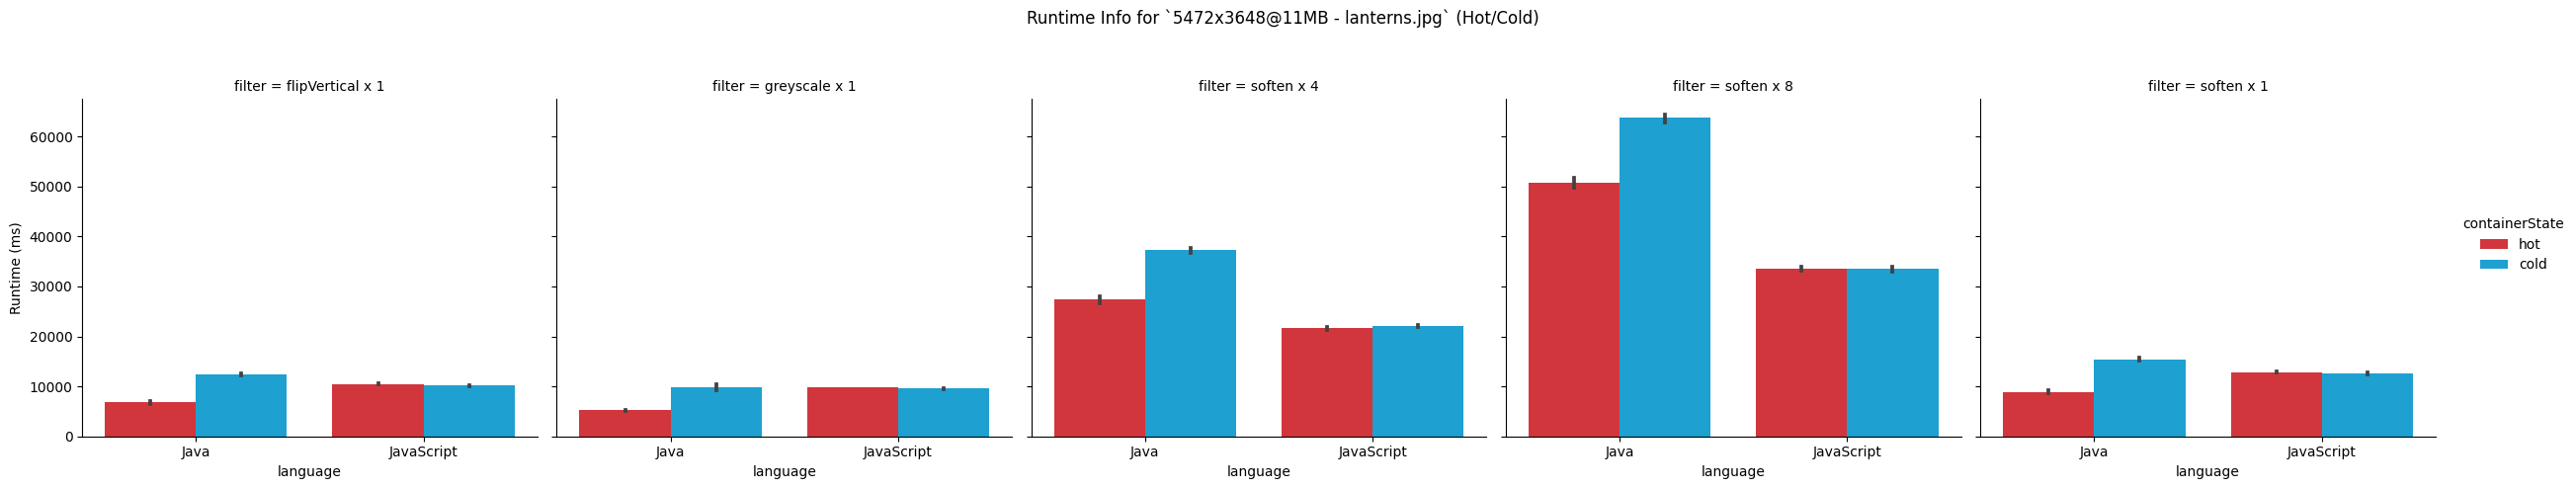

In [48]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename) &
    True
]

results = sns.catplot(
    data,
    kind="bar",
    x="language", y="runtime",
    hue="containerState",
    col="filter", palette=["#eb1c24", "#00adef"],
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Hot/Cold)")

display(global_widgets["filename"], results)

Dropdown(description='filename', index=5, options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466…

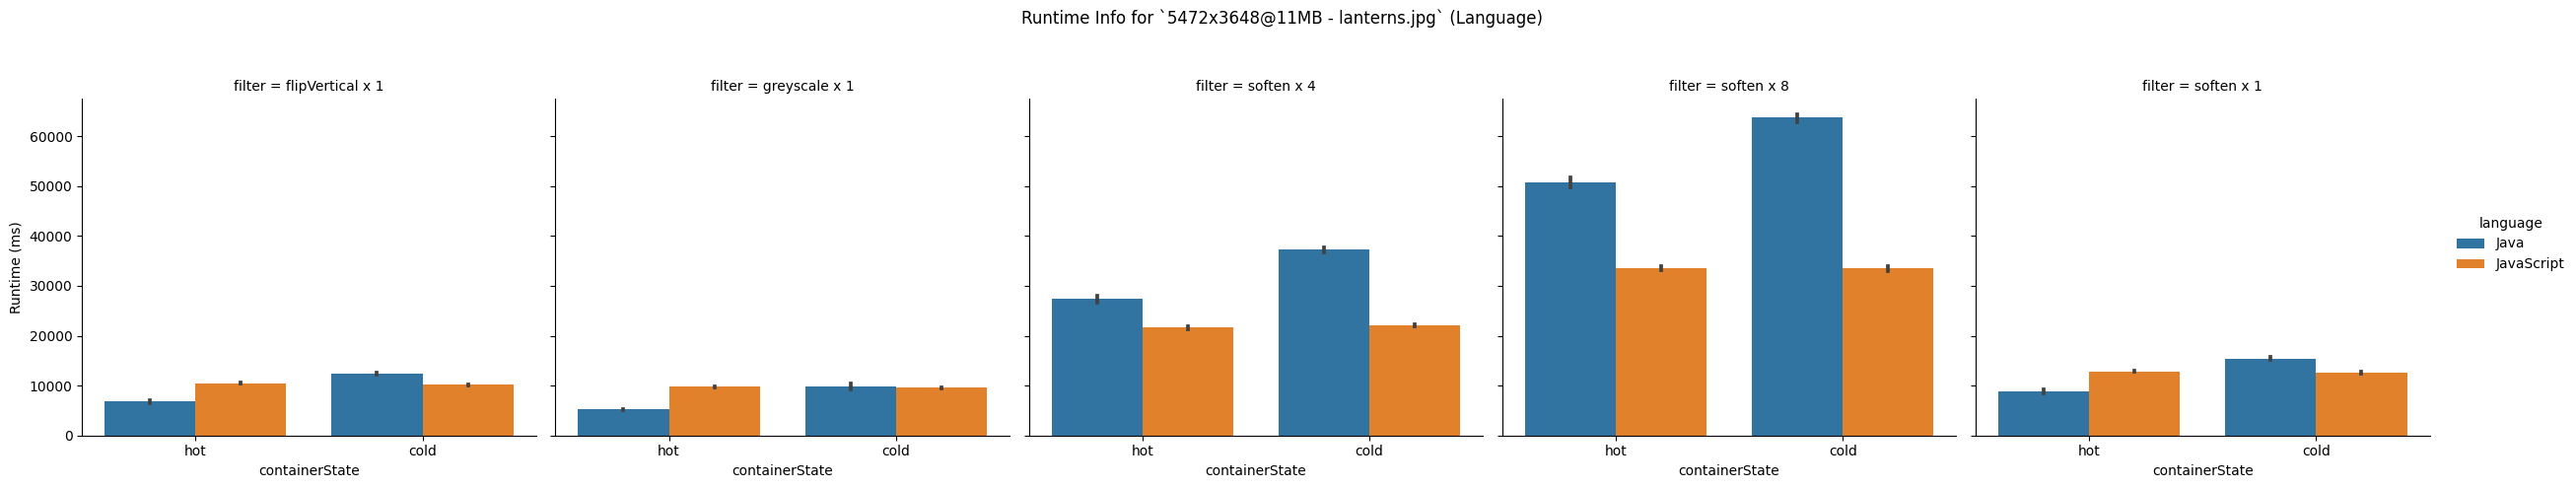

In [49]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename) &
    True
]

results = sns.catplot(
    data,
    kind="bar",
    x="containerState", y="runtime",
    hue="language",
    col="filter",
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Language)")

display(global_widgets["filename"], results)

Text(0.5, 0.98, 'Runtimes for Hot/Cold Containers')

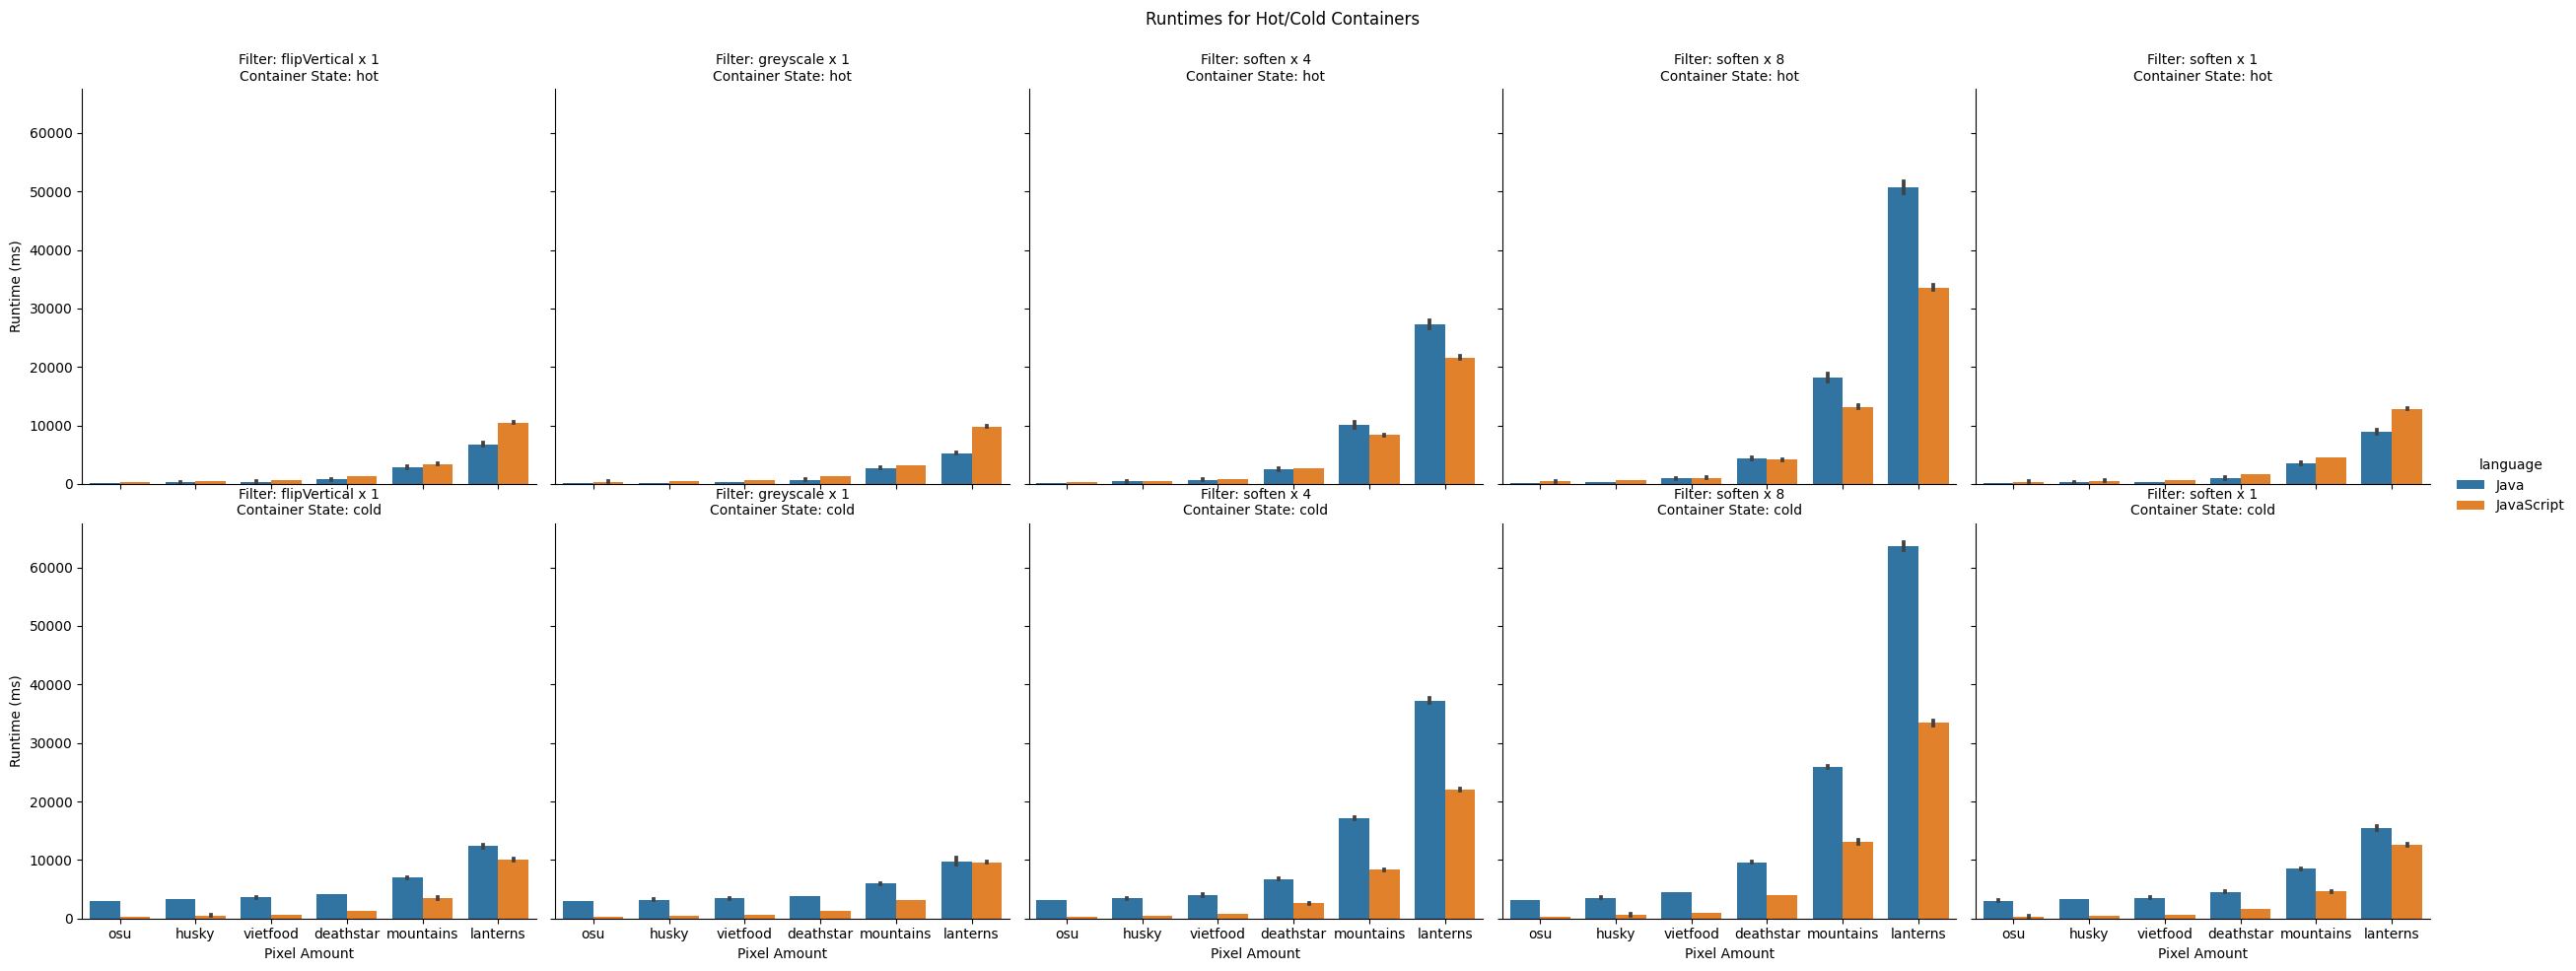

In [50]:
hot_cold_results = sns.catplot(
    df, x="shortName", y="runtime", hue="language",
    col="filter", row="containerState", kind="bar",
)
hot_cold_results.set_axis_labels("Pixel Amount", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")

In [24]:
grouped_columns = [
    # "cpuType",
    "filename", "filter", "containerState", "language",
]
data=df[
    (df["filename"] == global_widgets["filename"].value)
]

runtime_results = data.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

display(global_widgets["filename"], runtime_results)

Dropdown(description='filename', index=5, options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466…

average runtime (ms)  \
filename                      filter           containerState language                           
5472x3648@11MB - lanterns.jpg flipVertical x 1 cold           Java                12366.222222   
                                                              JavaScript          10125.684211   
                                               hot            Java                 6786.296296   
                                                              JavaScript          10497.043860   
                              greyscale x 1    cold           Java                 9754.657895   
                                                              JavaScript           9627.860465   
                                               hot            Java                 5259.436508   
                                                              JavaScript           9812.957265   
                              soften x 1       cold           Java                15402.163636   
                                                              JavaScript          12596.000000   
                                               hot            Java                 8863.989130   
                                                              JavaScript          12862.760000   
                              soften x 4       cold           Java                37248.698113   
                                                              JavaScript          22003.977273   
                                               hot            Java                27321.290323   
                                                              JavaScript          21646.140845   
                              soften x 8       cold           Java                63694.226415   
                                                              JavaScript          33513.408163   
                                               hot            Java                50750.695122   
                                                              JavaScript          33568.964706   

                                                                          standard deviation  \
filename                      filter           containerState language                         
5472x3648@11MB - lanterns.jpg flipVertical x 1 cold           Java                743.063282   
                                                              JavaScript          477.739899   
                                               hot            Java               1462.526001   
                                                              JavaScript          469.411143   
                              greyscale x 1    cold           Java               1743.448188   
                                                              JavaScript          350.361214   
                                               hot            Java                486.737605   
                                                              JavaScript          456.158083   
                              soften x 1       cold           Java               1396.346447   
                                                              JavaScript          772.043343   
                                               hot            Java               1646.619357   
                                                              JavaScript          492.118860   
                              soften x 4       cold           Java               1716.974783   
                                                              JavaScript          756.542056   
                                               hot            Java               2728.523388   
                                                              JavaScript         1218.016435   
                              soften x 8       cold           Java               2721.266098   
                                                              JavaScript         1817.049771 

Dropdown(description='language', index=1, options=('Java', 'JavaScript'), value='JavaScript')

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x 8', 'soft…

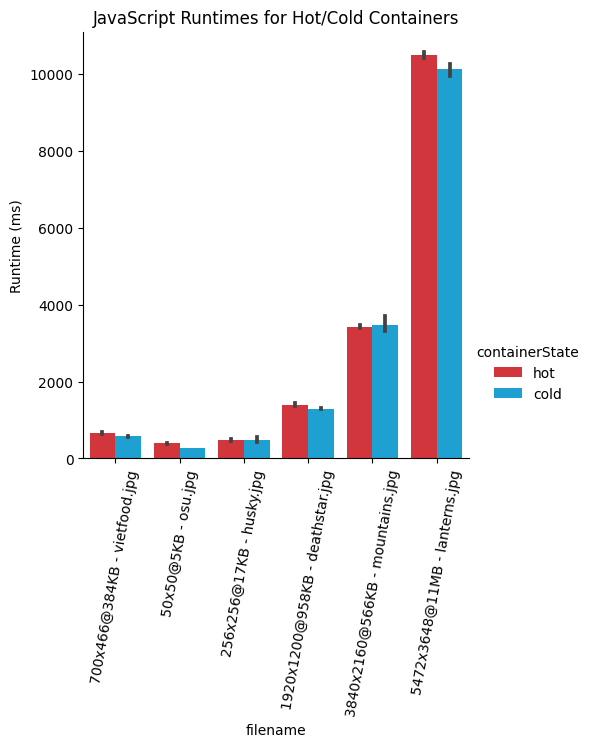

In [32]:
hot_cold = sns.catplot(
    df[
        (df["language"] == global_widgets["language"].value)
        & (df["filter"] == global_widgets["filter"].value)
    ],
    x="filename", y="runtime",
    hue="containerState",
    palette=["#eb1c24", "#00adef"],
    kind="bar",
)
hot_cold.set(
    title=f"{global_widgets['language'].value} Runtimes for Hot/Cold Containers")
hot_cold.set_ylabels("Runtime (ms)")
hot_cold.set_xticklabels(rotation=80)

display(
    hot_cold,
    global_widgets["language"],
    global_widgets["filter"],
)

Dropdown(description='language', index=1, options=('Java', 'JavaScript'), value='JavaScript')

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x 8', 'soft…

Dropdown(description='filename', index=5, options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466…

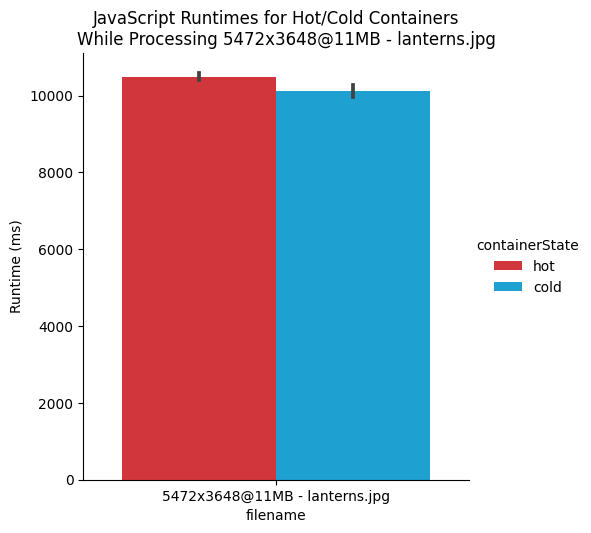

In [44]:
title = f"""
    {global_widgets['language'].value} Runtimes for Hot/Cold Containers
    While Processing {global_widgets['filename'].value}
""".strip()
hot_cold_specific = sns.catplot(
    df[
        (df["language"] == global_widgets["language"].value)
        & (df["filter"] == global_widgets["filter"].value)
        & (df["filename"] == global_widgets["filename"].value)
    ],
    x="filename", y="runtime",
    hue="containerState",
    palette=["#eb1c24", "#00adef"],
    kind="bar",
)
hot_cold_specific.set(title=title)
hot_cold_specific.set_ylabels("Runtime (ms)")

display(
    hot_cold_specific,
    global_widgets["language"],
    global_widgets["filter"],
    global_widgets["filename"],
)